# Idea: how does the described daytime changes during romance novels?

In [2]:
night = ['bedroom','moon','stars','dinner','supper','piyjama','pajama','sleeps','sleeping',
             'piyjamas','pajamas','moonlight','night','midnight','evening', 'went to bed',
        'go to bed', 'dusk', 'sunset', 'twilight', 'dark']
day = ['sun','sunshine','lunch','noon','afternoon','']
morning = ['morning','breakfast','woke up','get dressed', 'go to work', 'went to work',
          'on the way to work', 'arrived at work', 'alarm', 'sunrise', 'dawn', 'got up'
          ,'wake up']

In [3]:
import pandas as pd
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# get the filenames
filenames = glob.glob("/Users/alex/Desktop/Columbia/Algorithms/06-text-analysis-2/romance/*.txt")
contents = [open(filename).read() for filename in filenames]
romance_df = pd.DataFrame({
    'content': contents,
    'filename': filenames
})

In [5]:
# divide each content in six parts
romance_df['content_part1'] = romance_df.content.\
            apply(lambda content: content[0:(int(len(content)/6))])
romance_df['content_part2'] = romance_df.content.\
            apply(lambda content: content[(int(len(content)/6+1)):(int(len(content)/6*2))])
romance_df['content_part3'] = romance_df.content.\
            apply(lambda content: content[(int(len(content)/6*2+1)):(int(len(content)/6*3))])
romance_df['content_part4'] = romance_df.content.\
            apply(lambda content: content[(int(len(content)/6*3+1)):(int(len(content)/6*4))])
romance_df['content_part5'] = romance_df.content.\
            apply(lambda content: content[(int(len(content)/6*4+1)):(int(len(content)/6*5))])
romance_df['content_part6'] = romance_df.content.\
            apply(lambda content: content[(int(len(content)/6*5+1)):])

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

vocab = night+day+morning

list_wordcount = []

content_list = [romance_df.content_part1, romance_df.content_part2,\
                romance_df.content_part3, romance_df.content_part4,\
                romance_df.content_part5, romance_df.content_part6]

for this_content in content_list:
    vec = TfidfVectorizer(vocabulary = vocab,
                          ngram_range=(1, 3),
                     use_idf=False,
                     norm='l1')
    matrix = vec.fit_transform(this_content)
    vocab = vec.get_feature_names()
    wordcount_df = pd.DataFrame(matrix.toarray(), columns=vocab)
    list_wordcount.append(wordcount_df)

In [8]:
daytime_by_part = {}

part = 0

for wordcount in list_wordcount:
    part += 1
    this_daytime = {}
    this_daytime["night"] = wordcount[night].sum(axis=1).to_dict()
    this_daytime["day"] = wordcount[day].sum(axis=1).to_dict()
    this_daytime["morning"] = wordcount[morning].sum(axis=1).to_dict()
    daytime_by_part["part "+str(part)] = this_daytime

In [9]:
newdict = {(k1, k2, k3):v3 for k1,v1 in daytime_by_part.items() \
                       for k2,v2 in daytime_by_part[k1].items() \
                       for k3,v3 in daytime_by_part[k1][k2].items()}
df_time = pd.DataFrame([newdict[i] for i in sorted(newdict)],
                  index=pd.MultiIndex.from_tuples([i for i in sorted(newdict.keys())]))
df_time = df_time.reset_index()

In [10]:
df_time.rename(columns={'level_0':'part', \
                        'level_1':'daytime', 'level_2':'novel', 0:'score'}, inplace=True)

In [11]:
morning = df_time[df_time.daytime == 'morning']
day = df_time[df_time.daytime == 'day']
night = df_time[df_time.daytime == 'night']

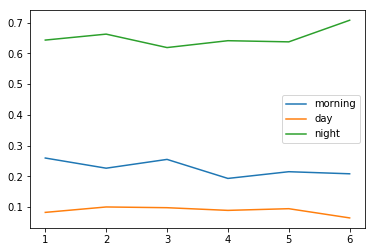

In [12]:
x = morning.groupby('part').part.min().str[5:6].astype(int)
y = morning.groupby('part').score.median()
plt.plot(x,y,label='morning')

x = day.groupby('part').part.min().str[5:6].astype(int)
y = day.groupby('part').score.median()
plt.plot(x,y,label='day')

x = night.groupby('part').part.min().str[5:6].astype(int)
y = night.groupby('part').score.median()
plt.plot(x,y,label='night')

plt.legend()

In [13]:
#scenes which play in the morning seem to be more frequent in the beginning of a book,
#while scenes playing at night seem to be more frequent at the end